In [ ]:
# load all data
import os
import polars as pl
data_dir = "./data/generated_features_nm_roll"
df = pl.DataFrame()
for name in os.listdir(data_dir):
    load_df = pl.read_parquet(os.path.join(data_dir, name))
    df = df.vstack(load_df)

df = df.with_columns(
    # pl.col("win").alias("win_total"),
    pl.col("win_c").alias("win_split"),
).drop(
    # pl.col("win"),
    pl.col("win_c"),
    pl.col("name_orig")
)

print(df.columns)
print(df)


['f1_min', 'f1_max', 'f1_std', 'f1_mean', 'f2_min', 'f2_max', 'f2_std', 'f2_mean', 'f3_min', 'f3_max', 'f3_std', 'f3_mean', 'f4_min', 'f4_max', 'f4_std', 'f4_mean', 'f5_min', 'f5_max', 'f5_std', 'f5_mean', 'f6_min', 'f6_max', 'f6_std', 'f6_mean', 'f7_min', 'f7_max', 'f7_std', 'f7_mean', 'f8_min', 'f8_max', 'f8_std', 'f8_mean', 'f30_min', 'f30_max', 'f30_std', 'f30_mean', 'f31_min', 'f31_max', 'f31_std', 'f31_mean', 'f11_min', 'f11_max', 'f11_std', 'f11_mean', 'f13_min', 'f13_max', 'f13_std', 'f13_mean', 'f14_min', 'f14_max', 'f14_std', 'f14_mean', 'f15_min', 'f15_max', 'f15_std', 'f15_mean', 'f17_min', 'f17_max', 'f17_std', 'f17_mean', 'f18_min', 'f18_max', 'f18_std', 'f18_mean', 'f19_min', 'f19_max', 'f19_std', 'f19_mean', 'music', 'name', 'win_split']
shape: (14_040, 71)
┌──────────┬──────────┬──────────┬──────────┬───┬────────────┬───────┬─────────────────┬───────────┐
│ f1_min   ┆ f1_max   ┆ f1_std   ┆ f1_mean  ┆ … ┆ f19_mean   ┆ music ┆ name            ┆ win_split │
│ ---      ┆ -

## Standard Deviation Of Outputs
This is to study the variance of output.

In [2]:
index_df = df.group_by((
        pl.col("name"),
        pl.col("music"),
        # pl.col("win_total"),
        pl.col("win_split"),
)).agg(
    pl.all().std().name.suffix("_agg_std"),
)

import matplotlib.pyplot as plt
import math

feats = df.drop("name", "music", "win_split", "num").columns
feats_raw = set()
for feat in feats:
    feat_name = feat.split("_")[0]
    feats_raw.add(feat_name)
fig, axs = plt.subplots(math.ceil(len(feats_raw) / 2), 2, layout="constrained", figsize=(8, 12))

aggs = ["min", "max", "mean", "std"]
for i, feat in enumerate(feats_raw):
    this_df = df.select(
        (pl.selectors.starts_with(f"{feat}_")),
    )

    ls = []
    labels=[]
    for agg in aggs:
        ls.append(index_df[f'{feat}_{agg}_agg_std'])
        labels.append(agg)

    x, y = i // 2, i % 2
    axs[x, y].boxplot(ls)
    axs[x, y].set_xticklabels(labels)
    axs[x, y].set_title(f"Standard Deviation Of Feature: {feat}")
plt.show()

ColumnNotFoundError: "num" not found

Resolved plan until failure:

	---> FAILED HERE RESOLVING THIS_NODE <---
DF ["f1_min", "f1_max", "f1_std", "f1_mean"]; PROJECT */71 COLUMNS; SELECTION: None

> **_NOTE:_** : Run this script to load all the R values for the various Pearson's R analysis.

In [7]:
# Analysis 3 - get r value of input to output
from scipy.stats import pearsonr
from tqdm import tqdm

input_df = pl.read_csv("input_features.csv").drop(
    pl.selectors.ends_with("_min"),
    pl.selectors.starts_with("f12_"),
    pl.selectors.starts_with("f16_"),
)

output_df = df.clone()
output_df = output_df.drop(
    pl.selectors.ends_with("_min"),
    pl.selectors.starts_with("f12_"),
    pl.selectors.starts_with("f16_"),
)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
name_df = df.clone()

# scale output
scaling_df = output_df.drop(
    pl.col("name"),
    # pl.col("num"),
    # pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
print(scaling_df.columns)
concat_df = output_df.select(
    pl.col("name"),
    # pl.col("num"),
    # pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
output_df = scaling_df.hstack(concat_df)

# scaling input
scaling_df = input_df.drop(
    pl.col("name")
)
print(scaling_df.columns)
concat_df = input_df.select(
    pl.col("name")
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
input_df = scaling_df.hstack(concat_df)
print(input_df)

names = input_df.filter(
    pl.col("name") != "dance_data_23_corrected"
)["name"].unique().to_list()
musics = output_df["music"].unique().to_list()


wins = df.with_columns(
    win_split_num = pl.col("win_split").cast(pl.Int64)
)["win_split_num"].sort().unique().to_list()
print(wins)

r_df = pl.DataFrame()
for name in tqdm(names):
    for music in musics:
        inputs = input_df.filter(pl.col("name") == name).drop("name").to_numpy()
        outputs = output_df.filter(
            pl.col("name") == name,
            pl.col("music") == music,
        ).drop("name", "music")

        for win in wins:
            output = outputs.filter(pl.col("win_split") == str(win)).drop("win_split").to_numpy()
            r = pearsonr(inputs[0, :], output[0, :], alternative="two-sided") 
            r_dict = {"name": name, "music": music, "win": win, "r": r.statistic}
            r_df = r_df.vstack(pl.from_dict(r_dict))
    
r_df.write_parquet("r_val_df.parquet")

['f1_max', 'f1_std', 'f1_mean', 'f2_max', 'f2_std', 'f2_mean', 'f3_max', 'f3_std', 'f3_mean', 'f4_max', 'f4_std', 'f4_mean', 'f5_max', 'f5_std', 'f5_mean', 'f6_max', 'f6_std', 'f6_mean', 'f7_max', 'f7_std', 'f7_mean', 'f8_max', 'f8_std', 'f8_mean', 'f30_max', 'f30_std', 'f30_mean', 'f31_max', 'f31_std', 'f31_mean', 'f11_max', 'f11_std', 'f11_mean', 'f13_max', 'f13_std', 'f13_mean', 'f14_max', 'f14_std', 'f14_mean', 'f15_max', 'f15_std', 'f15_mean', 'f17_max', 'f17_std', 'f17_mean', 'f18_max', 'f18_std', 'f18_mean', 'f19_max', 'f19_std', 'f19_mean']
['f1_max', 'f1_std', 'f1_mean', 'f2_max', 'f2_std', 'f2_mean', 'f3_max', 'f3_std', 'f3_mean', 'f4_max', 'f4_std', 'f4_mean', 'f5_max', 'f5_std', 'f5_mean', 'f6_max', 'f6_std', 'f6_mean', 'f7_max', 'f7_std', 'f7_mean', 'f8_max', 'f8_std', 'f8_mean', 'f30_max', 'f30_std', 'f30_mean', 'f31_max', 'f31_std', 'f31_mean', 'f11_max', 'f11_std', 'f11_mean', 'f13_max', 'f13_std', 'f13_mean', 'f14_max', 'f14_std', 'f14_mean', 'f15_max', 'f15_std', 'f15

  0%|          | 0/107 [00:00<?, ?it/s]

100%|██████████| 107/107 [01:42<00:00,  1.04it/s]


## Pearson's R Comparison Input and Output
We take the 3.7 second input motion and compare it against each 3.7 second segment from the output motion.
The first comparison is purely on the R value spread per time ordinal.
Time ordinal refers to which 3.7 second segment we are referring to.

win: 0 - 0.322973263341485
win: 1 - 0.2810263024188679
win: 2 - 0.26218355046198116
win: 3 - 0.25936329503002703
win: 4 - 0.254901174261359
win: 5 - 0.26183504805541324
win: 6 - 0.2676291981200796
win: 7 - 0.2683872265131271
win: 8 - 0.2608362501166741
win: 9 - 0.2552106119657109
win: 10 - 0.2535994524184265
win: 11 - 0.2575362227850561
win: 12 - 0.2547226901564428


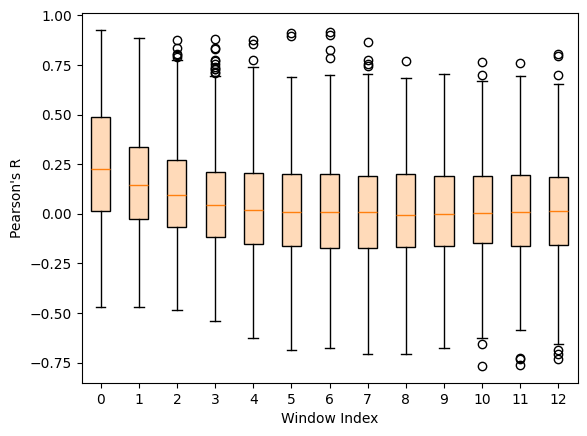

In [8]:
import matplotlib.pylab as plt

ax = plt.subplot()
r_list = []
r_mean_list = []
stds = []
for win in wins:
    rs = r_df.filter(
        pl.col("win") == win,
    ).drop(
        pl.col("name"),
        pl.col("music"),
    )["r"].to_numpy()
    r_list.append(rs)
    r_mean_list.append(rs.mean())
    print(f"win: {win} - {rs.std()}")
bp = ax.boxplot(r_list, patch_artist=True)
patches = bp["boxes"]
for patch in patches:
    patch.set_facecolor("peachpuff")
ax.set_xticklabels(wins)
ax.set_xlabel("Window Index")
ax.set_ylabel("Pearson's R")
plt.show()


## Pearson's R Comparison For Different Music Genres

We generated the output on 10 different genres of music as labeled by the AIST dance database dataset.
This comparison is to see the difference that different music genres has on the relevance of the input to the output per time ordinal.

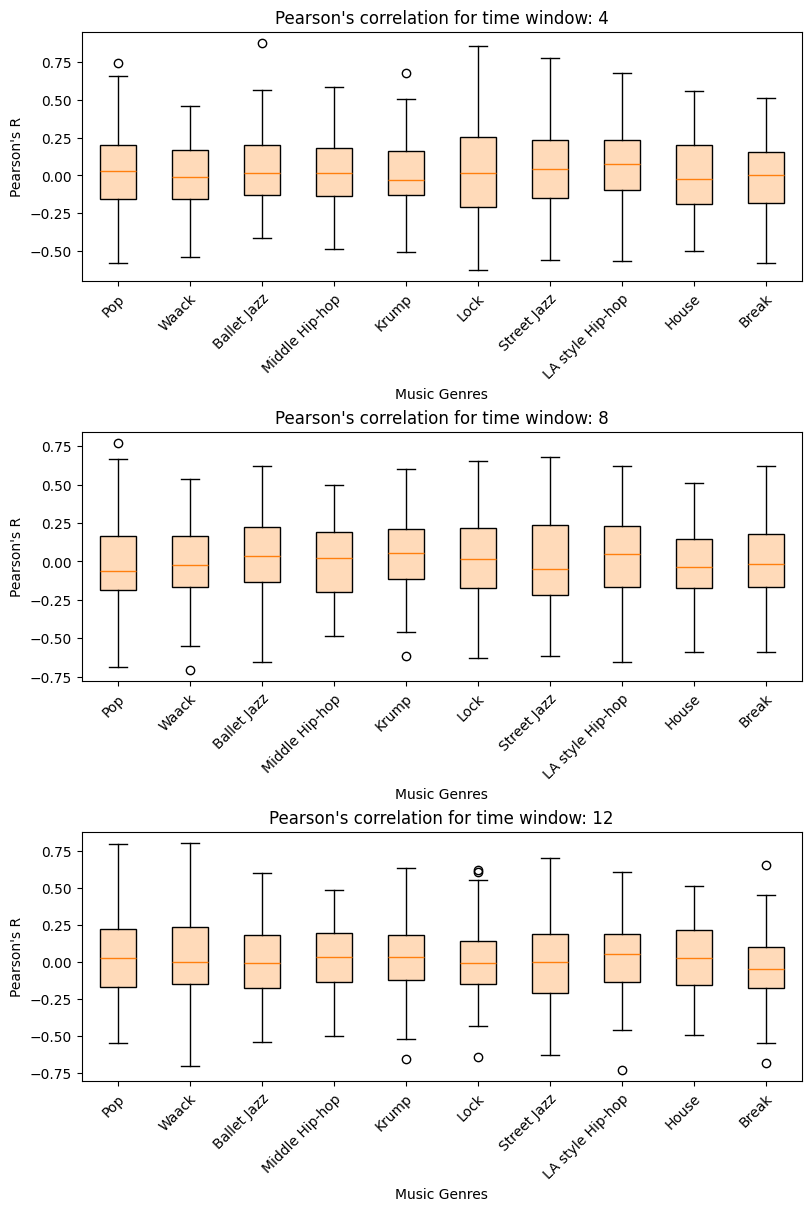

In [9]:
import matplotlib.pyplot as plt
import numpy as np

music_dict = {
    "mBR0": "Break",
    "mPO0": "Pop",
    "mLO0": "Lock",
    "mMH0": "Middle Hip-hop",
    "mLH0": "LA style Hip-hop",
    "mHO0": "House",
    "mWA0": "Waack",
    "mKR0": "Krump",
    "mJS0": "Street Jazz",
    "mJB0": "Ballet Jazz",
}

fig, axes = plt.subplots(3, 1, figsize=(8, 12), layout="constrained")
for i, win in enumerate([4, 8, 12]):
    r_list = []
    xlab_list = []
    for music in musics:
        rs = r_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
        ).drop(
            pl.col("name"),
            pl.col("music"),
        )["r"].to_numpy()
        r_list.append(rs)
        xlab_list.append(music_dict[music])
    bp = axes[i].boxplot(r_list, patch_artist=True)
    patches = bp["boxes"]
    for patch in patches:
        patch.set_facecolor("peachpuff")
    axes[i].set_xticklabels(xlab_list, rotation=45, ha="right", rotation_mode="anchor")
    axes[i].set_title(f"Pearson's correlation for time window: {win}")
    axes[i].set_xlabel("Music Genres")
    axes[i].set_ylabel("Pearson's R")
plt.show()

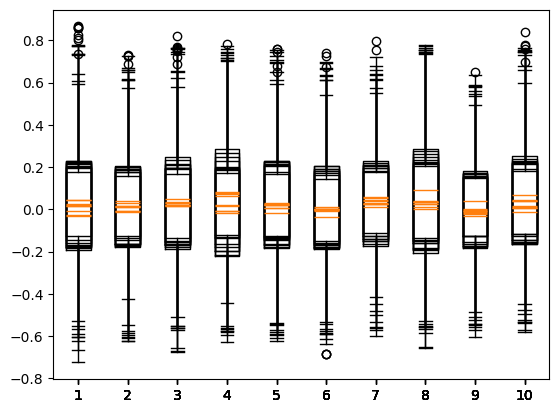

In [19]:
import matplotlib.pyplot as plt
import numpy as np

music_dict = {
    "mBR0": "Break",
    "mPO0": "Pop",
    "mLO0": "Lock",
    "mMH0": "Middle Hip-hop",
    "mLH0": "LA style Hip-hop",
    "mHO0": "House",
    "mWA0": "Waack",
    "mKR0": "Krump",
    "mJS0": "Street Jazz",
    "mJB0": "Ballet Jazz",
}

ax = plt.subplots()
for i, win in enumerate([4, 8, 12]):
    r_list = []
    for music in musics:
        rs = r_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
        ).drop(
            pl.col("name"),
            pl.col("music"),
        )["r"].to_numpy()
        r_list.append(rs)
    ax.boxplot(r_list)
plt.show()

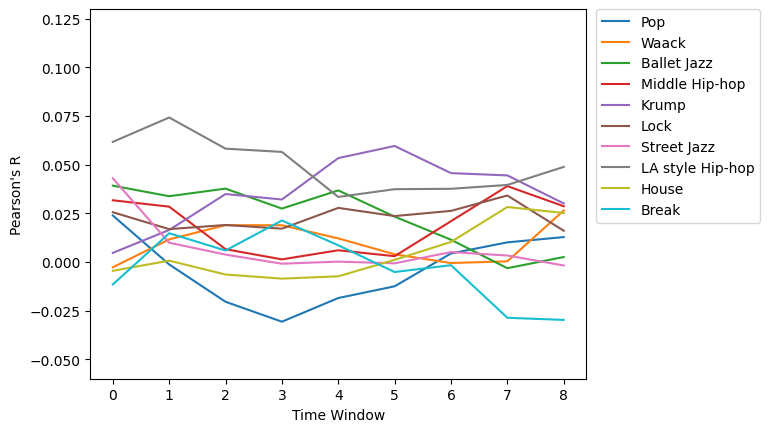

In [10]:
import matplotlib.pyplot as plt
import numpy as np

music_dict = {
    "mBR0": "Break",
    "mPO0": "Pop",
    "mLO0": "Lock",
    "mMH0": "Middle Hip-hop",
    "mLH0": "LA style Hip-hop",
    "mHO0": "House",
    "mWA0": "Waack",
    "mKR0": "Krump",
    "mJS0": "Street Jazz",
    "mJB0": "Ballet Jazz",
}

ax = plt.subplot()
for music in musics:
    r_list = []
    for win in wins[4:]:
        rs = r_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
        ).drop(
            pl.col("name"),
            pl.col("music"),
        )["r"].to_numpy()
        r_list.append(rs.mean())
    ax.plot(r_list, label=music_dict[music])
plt.xlabel("Time Window")
plt.ylabel("Pearson's R")
plt.ylim([-0.06, 0.13])
ax.legend(bbox_to_anchor=(1.35, 1), loc="upper right", borderaxespad=0)
plt.show()

## Pearson's R Comparison for Different Clusters

This comparison compares how input motion from different clusters has different relevance for their output

203


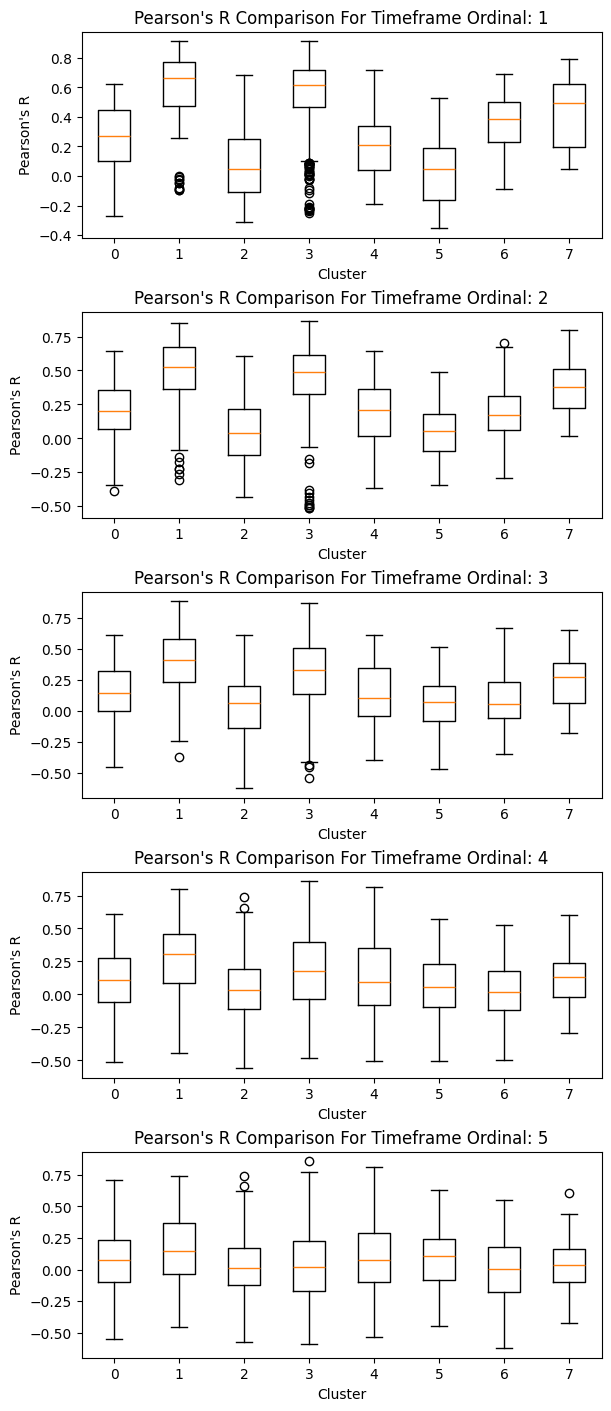

In [9]:

import matplotlib.pylab as plt

fig, axs = plt.subplots(5, 1, figsize=(6, 14), layout="constrained")
cluster_df = pl.read_csv("k-means-8n-final.csv")
joined_df = r_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()
debug_name = joined_df["name"].unique().to_list()
print(len(debug_name))

for win in range(0, 5):
    r_list = []
    for cluster in clusters:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        r_list.append(rs)
        
    axs[win].boxplot(r_list)
    axs[win].set_xticklabels(clusters)
    axs[win].set_xlabel("Cluster")
    axs[win].set_ylabel("Pearson's R")
    axs[win].set_title(f"Pearson's R Comparison For Timeframe Ordinal: {win + 1}")
plt.show()

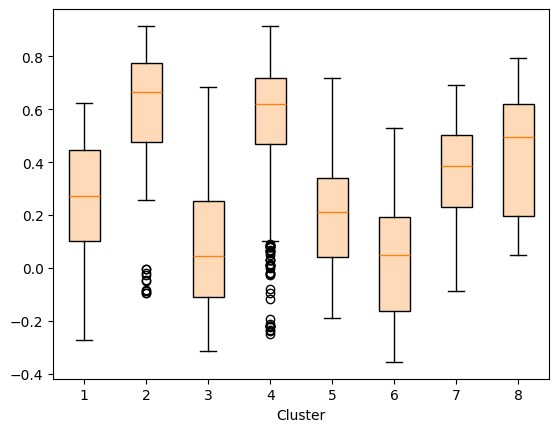

In [10]:

import matplotlib.pylab as plt

ax = plt.subplot()
cluster_df = pl.read_csv("k-means-8n-final.csv")
joined_df = r_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

r_list = []
for cluster in clusters:
    rs = joined_df.filter(
        pl.col("win") == 0,
        pl.col("cluster") == cluster,
    )["r"].to_numpy()
    r_list.append(rs)
    
bp = ax.boxplot(r_list, patch_artist=True)
patches = bp["boxes"]
for patch in patches:
    patch.set_facecolor("peachpuff")
ax.set_xticklabels([l + 1 for l in clusters])
plt.xlabel("Cluster")
plt.show()

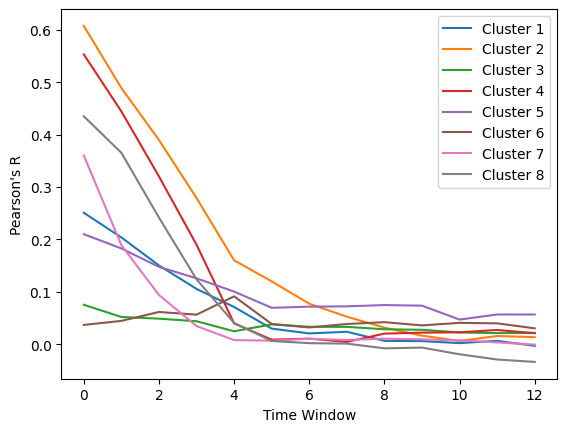

In [11]:

import matplotlib.pylab as plt

ax = plt.subplot()
cluster_df = pl.read_csv("k-means-8n-final.csv")
joined_df = r_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

for cluster in clusters:
    r_list = []
    for win in wins:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        r_list.append(rs.mean())
        
    ax.plot(r_list, label=f"Cluster {cluster + 1}")
plt.xlabel("Time Window")
plt.ylabel("Pearson's R")
plt.legend()
plt.show()

## Person's R Comparison For Different Music and Different Clusters
The purpose of this comparison is to see what cluster paired with what music generates highly relevant output, which what cluster and what music combination results in less relevant outputs.

**Still need to figure out a better way to display this information**

IndexError: index 4 is out of bounds for axis 0 with size 4

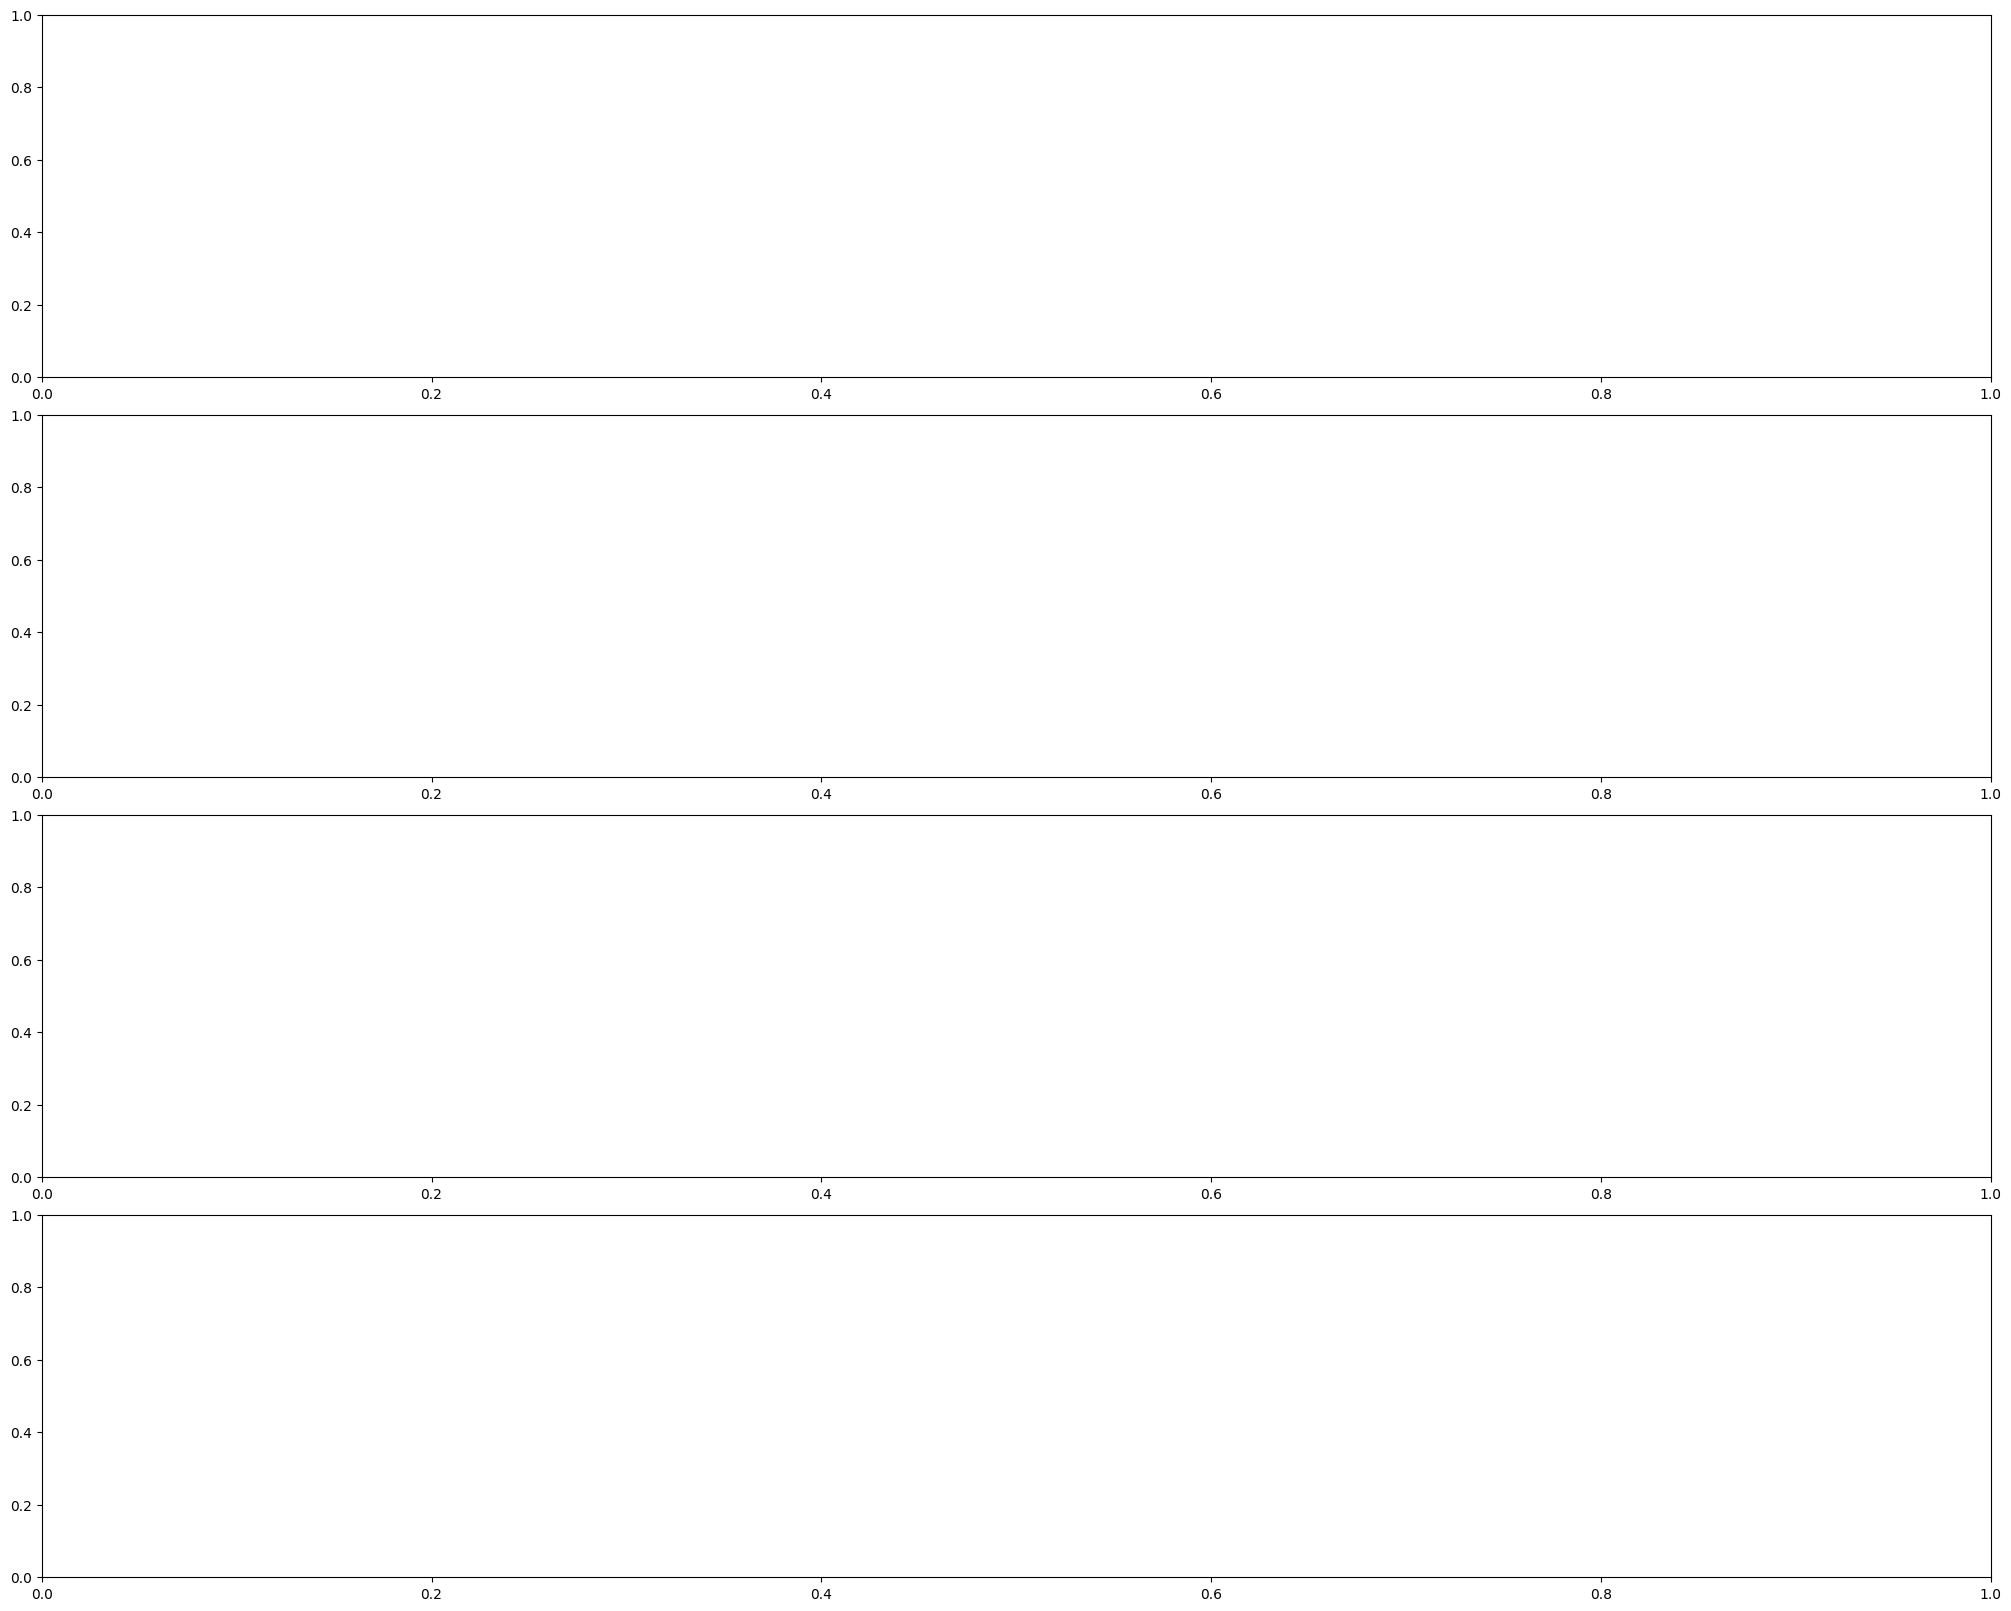

In [8]:
import matplotlib.pylab as plt

fig, axs = plt.subplots(4, 1, figsize=(20, 16), layout="constrained")
cluster_df = pl.read_csv("k-means-8n-final.csv").filter(
    pl.col("cluster") != 5
)
joined_df = r_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

for win in range(4, 12):
    r_list = []
    label_list = []
    for cluster in clusters:
        for music in musics:
            rs = joined_df.filter(
                pl.col("win") == win,
                pl.col("music") == music,
                pl.col("cluster") == cluster,
            )["r"].to_numpy()
            r_list.append(rs)
            label_list.append(f"cluster: {cluster} with {music}")
        
    axs[win].boxplot(r_list)
    axs[win].set_xticklabels(label_list, rotation=45, ha="right", rotation_mode="anchor")
    axs[win].set_xlabel("Cluster")
    axs[win].set_ylabel("Pearson's R")
    axs[win].set_title(f"Pearson's R Comparison For Timeframe Ordinal: {win + 1}")
plt.show()


## Per Genre Of Music, Find Which Cluster Grants Highest Mean R


ColumnNotFoundError: unable to find column "cluster"; valid columns: ["mean", "music", "label"]

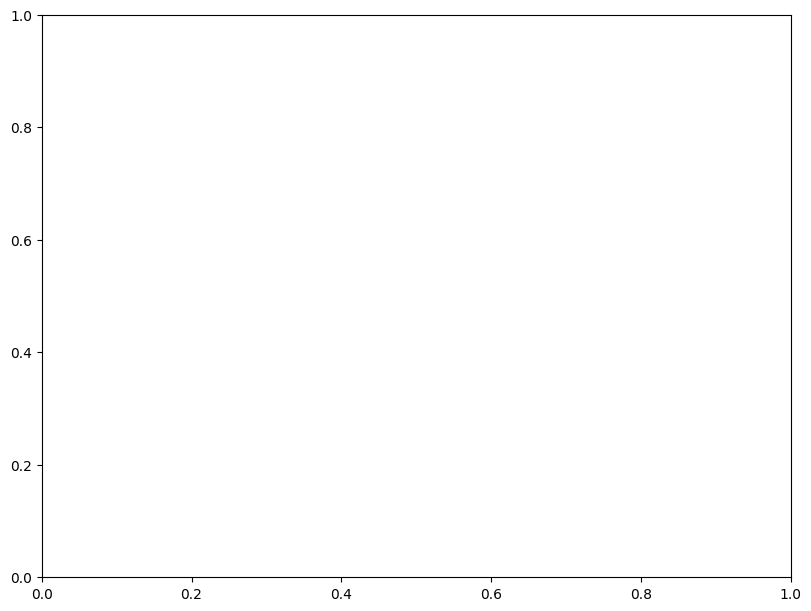

In [48]:

# Do this for ordinal 1 first
win_filter = 4
r_dict = {}
order_df = pl.DataFrame()
for cluster in clusters:
    for music in musics:
        rs = joined_df.filter(
            pl.col("win") == win_filter,
            pl.col("music") == music,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        music_name = music_dict[music]
        label = f"cluster: {cluster} with\n{music_name}"
        order_dict = {
            "mean": rs.mean(),
            "music": music,
            "label": label,
        }
        cur_df = pl.from_dict(order_dict)
        order_df = order_df.vstack(cur_df)

        for win in wins:
            r = joined_df.filter(
                pl.col("win") == win,
                pl.col("music") == music,
                pl.col("cluster") == cluster,
            )["r"].to_numpy()
            mean_r = np.mean(r)
            if label not in r_dict:
                r_dict[label] = [mean_r]
            else:
                r_dict[label].append(mean_r)
            

fig, ax = plt.subplots(1, 1, figsize=(8, 6), layout="constrained")
rs = []
labels = []
for music in musics:
    cur_df = order_df.filter(
        pl.col("music") == music
    )
    cur_df = cur_df.sort(by=pl.col("mean"), descending=True)
    row = cur_df.row(0, named=True)

    rs.append(r_dict[row["label"]])
    labels.append(row["label"])

for r, label in zip(rs, labels):
    print(r, label)
    ax.plot(r, label=label)
ax.set_xlabel("Music Cluster Combination")
ax.set_ylabel("Pearson's R")
ax.set_title("Pearson's R Comparison Most Impacted Cluster Per Music")


## Per Cluster, Find Which Genre Of Music Grants Highest Mean R

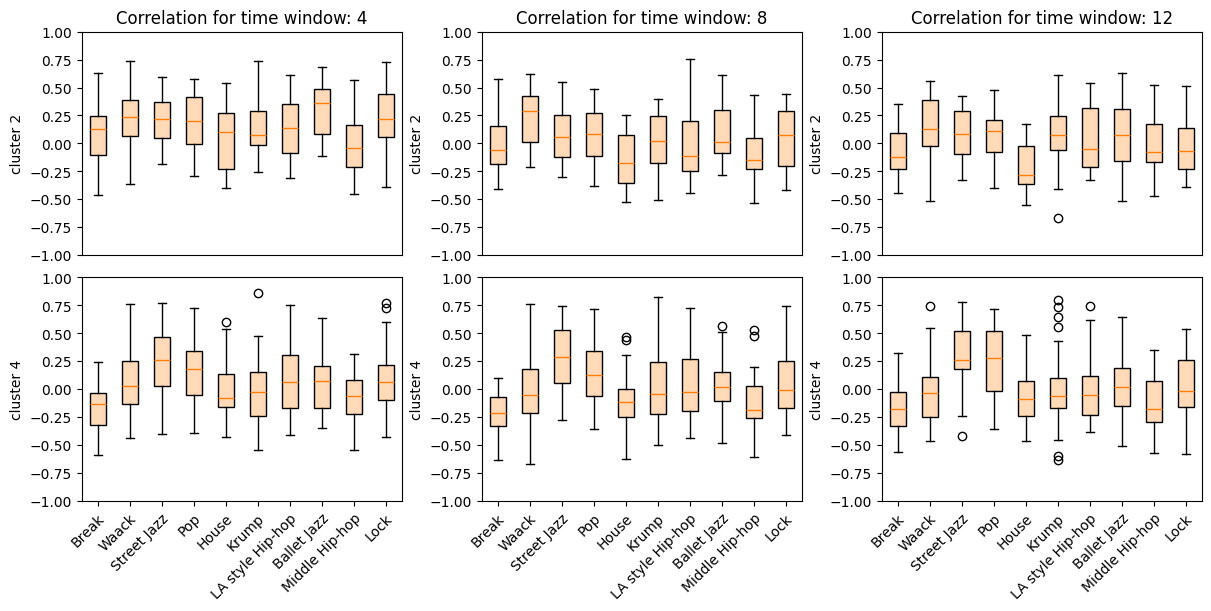

In [16]:


wins_sel = [4, 8, 12]

fig, axes = plt.subplots(2, len(wins_sel), figsize=(12, 6), layout="constrained")
for j, win in enumerate(wins_sel):
    axes[0, j].set_title(f"Correlation for time window: {win}")
    for i, cluster in enumerate([1, 3]):
        r_list = []
        labels = []
        for music in musics:
            rs = joined_df.filter(
                pl.col("win") == win,
                pl.col("music") == music,
                pl.col("cluster") == cluster,
            )["r"].to_numpy()
            r_list.append(rs)
            labels.append(music_dict[music])

        bp = axes[i, j].boxplot(r_list, patch_artist=True)
        axes[i, j].set_ylabel(f"cluster {cluster + 1}")
        patches = bp["boxes"]
        for patch in patches:
            patch.set_facecolor("peachpuff")
        if i != 1:
            axes[i, j].tick_params(
                axis='x',          # changes apply to the x-axis
                which='major',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False)
        else:
            axes[i, j].set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
        axes[i, j].set_ylim([-1.0, 1.0])
plt.show()

Text(0.5, 1.0, "Pearson's R Comparison For Best Music For Each Cluster")

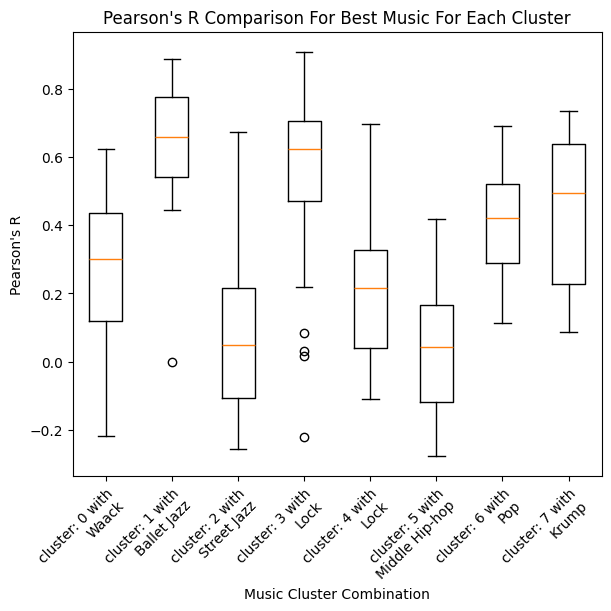

In [ ]:
import numpy as np

# Do this for ordinal 1 first
win = 0
r_dict = {}
order_df = pl.DataFrame()
for cluster in clusters:
    for music in musics:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        music_name = music_dict[music]
        label = f"cluster: {cluster} with\n{music_name}"
        r_dict[label] = rs
        order_dict = {
            "sort_key": np.quantile(rs, 0.1),
            "cluster": cluster,
            "label": label,
        }
        cur_df = pl.from_dict(order_dict)
        order_df = order_df.vstack(cur_df)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="constrained")
rs = []
labels = []
for cluster in clusters:
    cur_df = order_df.filter(
        pl.col("cluster") == cluster
    )
    cur_df = cur_df.sort(by=pl.col("sort_key"), descending=True)
    row = cur_df.row(0, named=True)

    rs.append(r_dict[row["label"]])
    labels.append(row["label"])

ax.boxplot(rs)
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel("Music Cluster Combination")
ax.set_ylabel("Pearson's R")
ax.set_title("Pearson's R Comparison For Best Music For Each Cluster")


## Per Music Genre, Find Which Cluster Grants Highest Mean R

Text(0.5, 1.0, "Pearson's R Comparison For Best Music For Each Cluster")

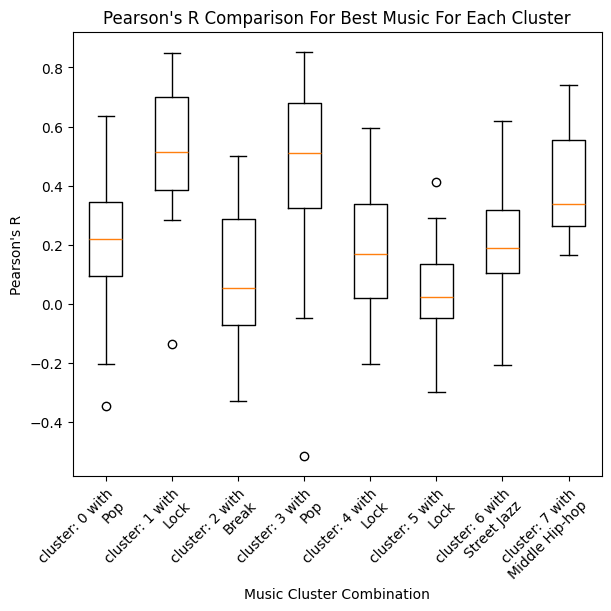

In [ ]:
import numpy as np

# Do this for ordinal 1 first
win = 1
r_dict = {}
order_df = pl.DataFrame()
for cluster in clusters:
    for music in musics:
        rs = joined_df.filter(
            pl.col("win") == win,
            pl.col("music") == music,
            pl.col("cluster") == cluster,
        )["r"].to_numpy()
        music_name = music_dict[music]
        label = f"cluster: {cluster} with\n{music_name}"
        r_dict[label] = rs
        order_dict = {
            "sort_key": np.quantile(rs, 0.1),
            "cluster": cluster,
            "label": label,
        }
        cur_df = pl.from_dict(order_dict)
        order_df = order_df.vstack(cur_df)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="constrained")
rs = []
labels = []
for cluster in clusters:
    cur_df = order_df.filter(
        pl.col("cluster") == cluster
    )
    cur_df = cur_df.sort(by=pl.col("sort_key"), descending=True)
    row = cur_df.row(0, named=True)

    rs.append(r_dict[row["label"]])
    labels.append(row["label"])

ax.boxplot(rs)
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel("Music Cluster Combination")
ax.set_ylabel("Pearson's R")
ax.set_title("Pearson's R Comparison For Best Music For Each Cluster")

In [1]:
# get overall highest correlations
best_name_music_df = joined_df.group_by(
    pl.col("name"), pl.col("music")
).agg(
    r = pl.quantile("r", 0.1)
).top_k(
    4, by="r"
)
bests = best_name_music_df.select(
    pl.col("name"),
    pl.col("music"),
)
bests.write_csv("best_dance_music_all_3.csv")

ax = plt.subplot()
for row in bests.iter_rows(named=True):
    name = row["name"]
    cluster = cluster_df.filter(
        pl.col("name") == name
    )["cluster"].to_list()[0]
    name_num = name.split("_")[2]
    music = row["music"]
    cur_df = joined_df.filter(
        pl.col("name") == name,
        pl.col("music") == music,
    )
    rs = []
    for win in wins:
        r = cur_df.filter(
            pl.col("win") == win
        )["r"].to_list()
        assert len(r) == 1, f"length of rs is not 1, is actually: {len(rs)}, music: {music}, name: {name}, win: {win}"
        rs.append(r)
        cluster = cluster_df.filter(
            pl.col("name") == name
        )["cluster"]
    ax.plot(wins, rs, "", label=f"dance {name_num}, with {music_dict[music]}")
ax.legend(bbox_to_anchor=(1.6, 1), loc="upper right", borderaxespad=0)
ax.set_xlabel("Time Window")
ax.set_ylabel("Pearson's R")
ax.set_title("Most Correlated Dance Pieces")
plt.show()
    
        



NameError: name 'joined_df' is not defined

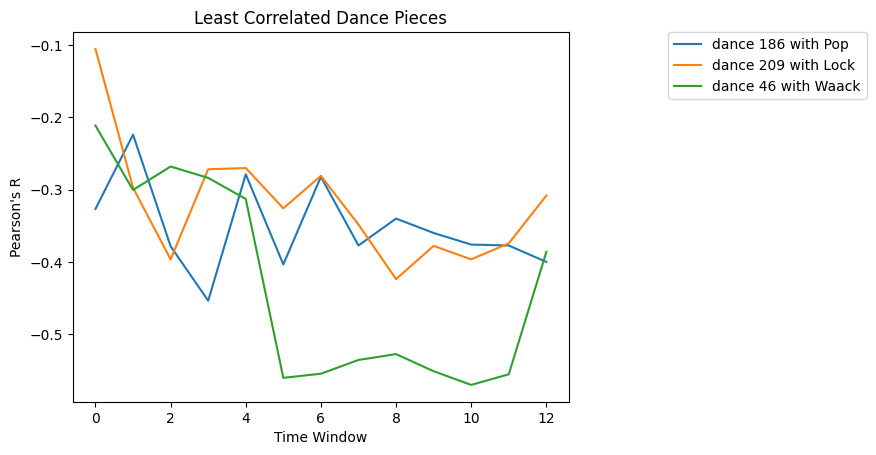

In [21]:

# get overall highest correlations
worst_name_music_df = joined_df.group_by(
    pl.col("name"), pl.col("music")
).agg(
    r = pl.quantile("r", 0.9)
).bottom_k(
    3, by="r"
)
worst = worst_name_music_df.select(
    pl.col("name"),
    pl.col("music"),
)
worst.write_csv("worst_dance_music_all_3.csv")

ax = plt.subplot()
for row in worst.iter_rows(named=True):
    name = row["name"]
    name_num = name.split("_")[2]
    music = row["music"]
    cur_df = joined_df.filter(
        pl.col("name") == name,
        pl.col("music") == music,
    )
    rs = []
    for win in wins:
        r = cur_df.filter(
            pl.col("win") == win
        )["r"].to_list()
        assert len(r) == 1, f"length of rs is not 1, is actually: {len(rs)}, music: {music}, name: {name}, win: {win}"
        rs.append(r)
    ax.plot(wins, rs, "", label=f"dance {name_num} with {music_dict[music]}")
ax.legend(bbox_to_anchor=(1.6, 1), loc="upper right", borderaxespad=0)
ax.set_xlabel("Time Window")
ax.set_ylabel("Pearson's R")
ax.set_title("Least Correlated Dance Pieces")
plt.show()

## Method 2: Using Euclidean Distance To Measure Similarity Of Motion

In [11]:
# Analysis 3 - get r value of input to output
from scipy.stats import pearsonr
from tqdm import tqdm
import math

def euclid_dist(pt1, pt2):
    dist = 0
    for f1, f2 in zip(pt1, pt2):
        dist += (f1 - f2) ** 2
    return math.sqrt(dist)


input_df = pl.read_csv("features_complete.csv") 
output_df = df.clone()
output_df = output_df.drop(
    pl.selectors.ends_with("_min"),
    pl.selectors.starts_with("f12_"),
    pl.selectors.starts_with("f16_"),
)
# scale output
scaling_df = output_df.drop(
    pl.col("name"),
    pl.col("num"),
    pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
concat_df = output_df.select(
    pl.col("name"),
    pl.col("num"),
    pl.col("win_total"),
    pl.col("win_split"),
    pl.col("music"),
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
output_df = scaling_df.hstack(concat_df)
print(output_df)

# scaling input
scaling_df = input_df.drop(
    pl.col("name")
)
concat_df = input_df.select(
    pl.col("name")
)
scaling_df = pl.DataFrame(scaler.fit_transform(scaling_df))
input_df = scaling_df.hstack(concat_df)
print(input_df)

names = input_df.filter(
    pl.col("name") != "dance_data_23_corrected"
)["name"].unique().to_list()
musics = output_df["music"].unique().to_list()


euc_df = pl.DataFrame()
for name in tqdm(names):
    for music in musics:
        inputs = input_df.filter(pl.col("name") == name).drop("name").to_numpy()
        outputs = output_df.filter(
            pl.col("name") == name,
            pl.col("num") == "0",
            pl.col("win_total") == "3",
            pl.col("music") == music,
        ).drop("name", "num", "win_total", "music")

        for win in range(0, 4):
            output = outputs.filter(pl.col("win_split") == str(win)).drop("win_split").to_numpy()
            euc_dist = euclid_dist(inputs[0, :], output[0, :])
            euc_dict = {"name": name, "music": music, "win": win, "euc": euc_dist}
            euc_df = euc_df.vstack(pl.from_dict(euc_dict))
    
euc_df.write_parquet("r_val_df.parquet")

shape: (191_700, 56)
┌───────────┬───────────┬───────────┬───────────┬───┬─────┬───────────┬───────────┬───────┐
│ column_0  ┆ column_1  ┆ column_2  ┆ column_3  ┆ … ┆ num ┆ win_total ┆ win_split ┆ music │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ --- ┆ ---       ┆ ---       ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ str ┆ str       ┆ str       ┆ str   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═════╪═══════════╪═══════════╪═══════╡
│ -0.675401 ┆ 1.25513   ┆ -1.512881 ┆ 0.507833  ┆ … ┆ 9   ┆ 1         ┆ 0         ┆ mJS0  │
│ 0.228852  ┆ -0.977964 ┆ 0.753469  ┆ 0.493649  ┆ … ┆ 9   ┆ 3         ┆ 3         ┆ mJS0  │
│ -4.709402 ┆ 1.148645  ┆ -3.15279  ┆ 0.670895  ┆ … ┆ 4   ┆ 2         ┆ 2         ┆ mMH0  │
│ 0.212938  ┆ -1.078354 ┆ 0.761838  ┆ -0.654888 ┆ … ┆ 7   ┆ 3         ┆ 0         ┆ mJS0  │
│ 0.244293  ┆ -0.290751 ┆ 0.359497  ┆ -0.360815 ┆ … ┆ 3   ┆ 3         ┆ 3         ┆ mLO0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …   ┆

 62%|██████▏   | 133/213 [00:12<00:07, 10.27it/s]


KeyboardInterrupt: 

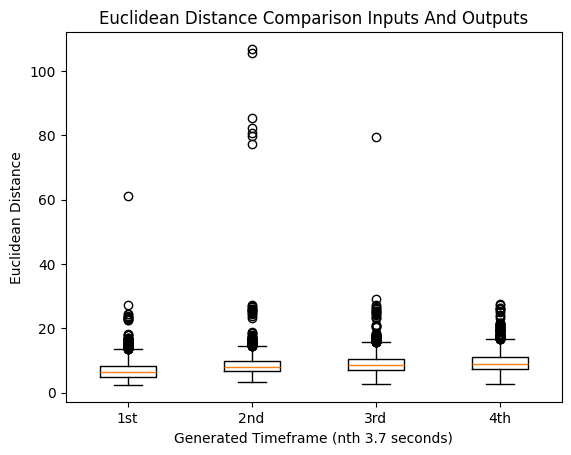

In [23]:
import matplotlib.pylab as plt

ax = plt.subplot()

euc_list = []
for win in range(0, 4):
    euc_dists = euc_df.filter(
        pl.col("win") == win,
    ).drop(
        pl.col("name"),
        pl.col("music"),
    )["euc"].to_numpy()
    euc_list.append(euc_dists)
ax.boxplot(euc_list)
ax.set_xticklabels(["1st", "2nd", "3rd", "4th"])
ax.set_xlabel("Generated Timeframe (nth 3.7 seconds)")
ax.set_ylabel("Euclidean Distance")
ax.set_title("Euclidean Distance Comparison Inputs And Outputs")
plt.show()

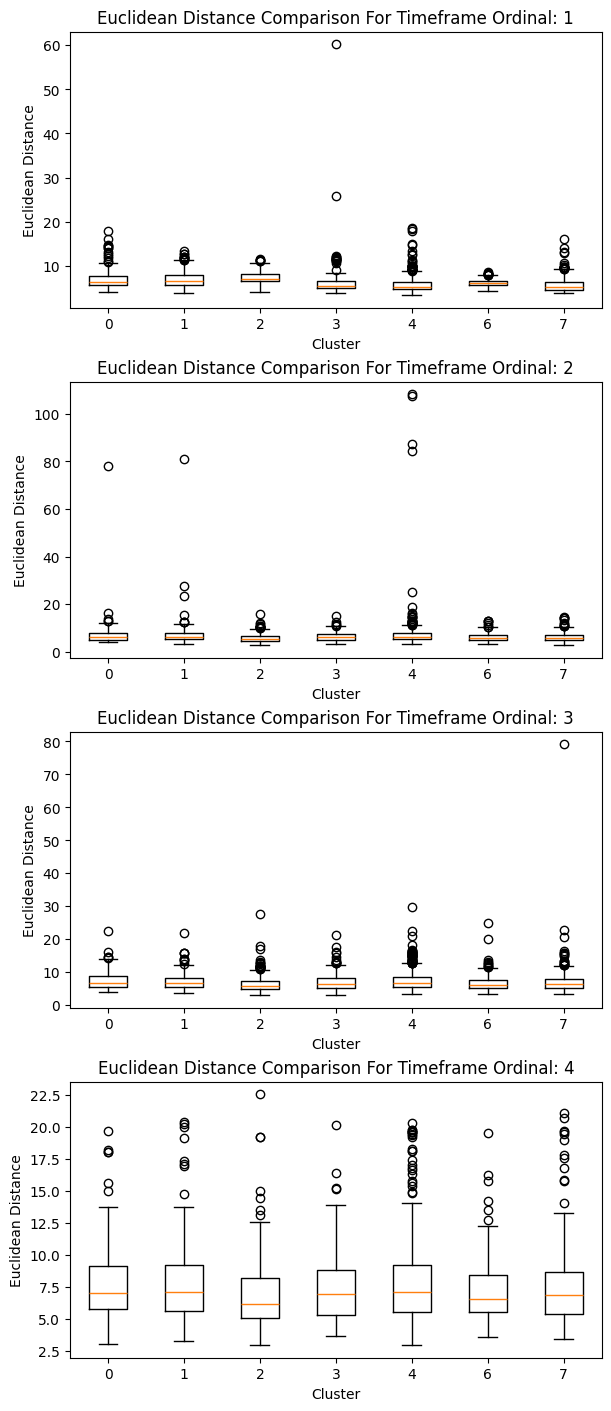

In [35]:
import matplotlib.pylab as plt

fig, axs = plt.subplots(4, 1, figsize=(6, 14), layout="constrained")
cluster_df = pl.read_csv("k-means-8n-final.csv").filter(
    pl.col("cluster") != 5
)
joined_df = euc_df.join(
    cluster_df,
    on=pl.col("name"),
    how="inner"
)
clusters = cluster_df["cluster"].unique().to_list()

for win in range(0, 4):
    euc_list = []
    for cluster in clusters:
        euc_dists = joined_df.filter(
            pl.col("win") == win,
            pl.col("cluster") == cluster,
        )["euc"].to_numpy()
        euc_list.append(euc_dists)
        
    axs[win].boxplot(euc_list)
    axs[win].set_xticklabels(clusters)
    axs[win].set_xlabel("Cluster")
    axs[win].set_ylabel("Euclidean Distance")
    axs[win].set_title(f"Euclidean Distance Comparison For Timeframe Ordinal: {win + 1}")